In [2]:
import pandas as pd
import numpy as np
import scipy.stats as st
import seaborn as sns
import sys
import os
import gseapy as gp
import matplotlib.pyplot as plt
import swan_vis as swan
import yaml
from snakemake.io import expand

p = os.path.dirname(os.path.dirname(os.getcwd()))
sys.path.append(p)

from proc_revisions.utils import *
from proc_revisions.mane_utils import *
from proc_revisions.plotting import *

In [3]:
od = '../../proc_revisions/'
config_file = f'{od}/config.yml'
with open(config_file) as f:
    config = yaml.safe_load(f)

In [4]:
ab = od+expand(config['lr']['talon']['fusion_fix']['ab'], species='human')[0]
filt_ab = od+expand(config['lr']['cerberus']['filt_ab'], species='human')[0]
read_annot = od+expand(config['lr']['talon']['full_annot'], species='human')[0]
t_metadata = od+expand(config['ref']['cerberus']['new_gtf_t_info'], species='human')[0]
lib_meta = od+expand(config['lr']['meta'], species='human')[0]
swan_file = od+expand(config['lr']['swan']['sg'], species='human')[0]
cerberus_h5 = od+expand(config['lr']['cerberus']['ca_triplets'], species='human', obs_col='sample')[0]
cerb_t_metadata = od+expand(config['lr']['cerberus']['gtf_t_info'], species='human')[0]
major_isos = od+expand(config['lr']['analysis']['major_isos'], species='human', obs_col='sample')[0]
pi_tpm_table = od+expand(config['lr']['mane']['pi_tpm']['triplet'], species='human', obs_col='sample')[0]
dataset_exp_gene = od+expand(config['lr']['mane']['exp_gene_subset'], species='human', obs_col='dataset')[0]
sample_exp_gene = od+expand(config['lr']['mane']['exp_gene_subset'], species='human', obs_col='sample')[0]
pp_summary = od+expand(config['lr']['protein_pred']['summary'], species='human')[0]


ref_t_metadata = od+expand(config['ref']['new_gtf_t_info'], species='human')[0]
ref_g_metadata = od+expand(config['ref']['new_gtf_g_info'], species='human')[0]

# pp_summary = '../'+expand(config['data']['p_pred']['summary'], species='human')[0]

m_lib_meta = od+expand(config['lr']['meta'], species='mouse')[0]

# orf_fa = '../'+expand(config['data']['p_pred']['orf_fa'], species='human')[0]
# pp_bed = '../'+expand(config['data']['p_pred']['cds_bed'], species='human')[0]

ver = 'v40_cerberus'
min_tpm = 1
gene_subset = 'protein_coding'
obs_col = 'sample'
go_gene_subset = 'protein_coding'


# Figures 4 and S11

## MANE analyses using libraries

In [4]:
# sg = swan.read(swan_file)
# ca = cerberus.read(cerberus_h5)
# mp_dfs = mane_analysis(sg, ca, 
#                        ref_t_metadata,
#                        ref_g_metadata,
#                        'dataset',
#                        min_tpm,
#                        dataset_exp_gene,
#                        config['lr']['mane']['pi_tpm'])

In [5]:
# get mane and non-mane intron chain IDs
df = mp_dfs['ic']

nm_df = df.loc[df.ic_princ_is_mane==False].copy(deep=True)[['ic_id_princ']].drop_duplicates()
nm_df.rename({'ic_id_princ': 'Name'}, axis=1, inplace=True)
nm_df = cerberus.split_cerberus_id(nm_df, 'ic')

In [6]:
mane_df = nm_df[['gene_id']].drop_duplicates()
mane_df['Name'] = mane_df['gene_id']+'_'+'1'

In [7]:
# get ic coords for each non mane predom ic and for mane ics
ca = cerberus.read(cerberus_h5)

In [8]:
ic_df = ca.ic.copy(deep=True)
ic_df.drop('gene_id', axis=1, inplace=True)
nm_df = nm_df.merge(ic_df, how='left', on='Name')
mane_df = mane_df.merge(ic_df, how='left', on='Name')

In [9]:
nm_df = nm_df[['Name', 'Coordinates', 'novelty', 'gene_id']]
mane_df = mane_df[['Name', 'Coordinates', 'gene_id']]
df = nm_df.merge(mane_df, on=['gene_id'], how='left', suffixes=('_predom', '_mane'))

In [10]:
# remove unspliced transcripts as definitionally they cannot
df['predom_subset_of_mane'] = df.apply(lambda x: x['Coordinates_predom'] in x['Coordinates_mane'] and x['Coordinates_predom'] != '-', axis=1)

In [11]:
temp = df[['Name_predom', 'predom_subset_of_mane']].groupby('predom_subset_of_mane').count().reset_index()
n = len(nm_df)
n_num = temp.loc[temp.predom_subset_of_mane==True, 'Name_predom'].values[0]
print(f'{(n_num/n)*100:.2f}% of non-mane predom ICs ({n_num}/{n}) are partial splice matches to MANE ICs')

30.68% of non-mane predom ICs (10301/33580) are partial splice matches to MANE ICs


In [12]:
temp = df[['Name_predom', 'novelty', 'predom_subset_of_mane']].groupby(['predom_subset_of_mane', 'novelty']).count().reset_index()
n_num_2 = temp.loc[(temp.novelty=='Known')&(temp.predom_subset_of_mane==True), 'Name_predom'].values[0]
print(f'{(n_num_2/n_num)*100:.2f}% of non-MANE subset predom ICs ({n_num_2}/{n_num}) are annotated')

56.71% of non-MANE subset predom ICs (5842/10301) are annotated


In [13]:
## how often are non-mane predominant isoforms from mane clinical?

In [14]:
df = mp_dfs['triplet']

In [15]:
# get list of non-mane predom tids
df = df[['tid_princ']].drop_duplicates()
df = df.rename({'tid_princ': 'predom_tid'}, axis=1)
df['gid'] = df.predom_tid.str.split('[', n=1, expand=True)[0]

In [16]:
gtf_df, _, _ = get_gtf_info(how='iso', ver='v40_cerberus')

In [17]:
# get all mane tids, including select and plus clinical
mane_tids = gtf_df.loc[(gtf_df.MANE_Select==True)].tid.tolist()
print(len(mane_tids))
mane_tids = gtf_df.loc[(gtf_df.MANE_Select==True)|(gtf_df.MANE_Plus_Clinical==True)].tid.tolist()
print(len(mane_tids))
df['not_mane'] = ~df.predom_tid.isin(mane_tids)

18600
18656


In [18]:
temp = df[['gid', 'not_mane']].groupby('gid').any().reset_index().groupby('not_mane').count().reset_index()
n = temp['gid'].sum()
n_num = temp.loc[temp.not_mane==True, 'gid'].values[0]
print(f'{(n_num/n)*100:.2f}% of MANE genes ({n_num}/{n}) have >=1 library where predom iso != MANE')

85.61% of MANE genes (14396/16816) have >=1 library where predom iso != MANE


In [19]:
temp = df[['gid', 'not_mane']].groupby('gid').any().reset_index().groupby('not_mane').count().reset_index()
n = temp['gid'].sum()
n_num = temp.loc[temp.not_mane==True, 'gid'].values[0]
print(f'{(n_num/n)*100:.2f}% of MANE genes ({n_num}/{n}) have >=1 library where predom iso != MANE')

85.61% of MANE genes (14396/16816) have >=1 library where predom iso != MANE


## How many non MANE predominant isoforms encode for a different ORF than MANE?
"For non-MANE predominant transcripts, only 17.0\% were predicted to have the same ORF as the MANE transcript. Furthermore, 62.1\% of non-MANE predominant transcripts are predicted to encode for a full ORF that does not undergo NMD."

In [1]:
import pandas as pd
import numpy as np
import scipy.stats as st
import seaborn as sns
import sys
import os
import gseapy as gp
import matplotlib.pyplot as plt
import swan_vis as swan
import yaml
from snakemake.io import expand

p = os.path.dirname(os.path.dirname(os.getcwd()))
sys.path.append(p)

from proc_revisions.utils import *
from proc_revisions.mane_utils import *
from proc_revisions.plotting import *
od = '../../proc_revisions/'
config_file = f'{od}/config.yml'
with open(config_file) as f:
    config = yaml.safe_load(f)
ab = od+expand(config['lr']['talon']['fusion_fix']['ab'], species='human')[0]
filt_ab = od+expand(config['lr']['cerberus']['filt_ab'], species='human')[0]
read_annot = od+expand(config['lr']['talon']['full_annot'], species='human')[0]
t_metadata = od+expand(config['ref']['cerberus']['new_gtf_t_info'], species='human')[0]
lib_meta = od+expand(config['lr']['meta'], species='human')[0]
swan_file = od+expand(config['lr']['swan']['sg'], species='human')[0]
cerberus_h5 = od+expand(config['lr']['cerberus']['ca_triplets'], species='human', obs_col='sample')[0]
cerb_t_metadata = od+expand(config['lr']['cerberus']['gtf_t_info'], species='human')[0]
major_isos = od+expand(config['lr']['analysis']['major_isos'], species='human', obs_col='sample')[0]
pi_tpm_table = od+expand(config['lr']['mane']['pi_tpm']['triplet'], species='human', obs_col='sample')[0]
dataset_exp_gene = od+expand(config['lr']['mane']['exp_gene_subset'], species='human', obs_col='dataset')[0]
sample_exp_gene = od+expand(config['lr']['mane']['exp_gene_subset'], species='human', obs_col='sample')[0]
pp_summary = od+expand(config['lr']['protein_pred']['summary'], species='human')[0]


ref_t_metadata = od+expand(config['ref']['new_gtf_t_info'], species='human')[0]
ref_g_metadata = od+expand(config['ref']['new_gtf_g_info'], species='human')[0]

# pp_summary = '../'+expand(config['data']['p_pred']['summary'], species='human')[0]

m_lib_meta = od+expand(config['lr']['meta'], species='mouse')[0]

# orf_fa = '../'+expand(config['data']['p_pred']['orf_fa'], species='human')[0]
# pp_bed = '../'+expand(config['data']['p_pred']['cds_bed'], species='human')[0]

ver = 'v40_cerberus'
min_tpm = 1
gene_subset = 'protein_coding'
obs_col = 'sample'
go_gene_subset = 'protein_coding'



Read in graph from ../../proc_revisions/data/human/lr/swan/swan_graph.p
triplet
# genes: 16816
68.57% (11531/16816) of genes have a non-MANE predominant triplet in 80% of expressed datasets
14.38% of genes (2418/16816) have predom == mane in all datasets
28.28% of genes (4756/16816) have predom != mane in all datasets
32.87% (291184/885967) ranked gene / library combinations where predominant isoform is not MANE
72.90% (433602/594783) of gene / dataset combos where MANE is predominant triplet also have a secondary expressed triplet
33.74% (255313/756666) of gene / dataset combos  where predominant triplet is not MANE have MANE expression
66.26% (501353/756666) of gene / dataset combos  where predominant triplet is not MANE have NO MANE expression
85.62% (14398/16816) of genes have >= 1 dataset where the predominant triplet is not MANE
71.72% (12060/16816) of genes have >= 1 dataset where the predominant triplet is MANE

tss
ic
tes


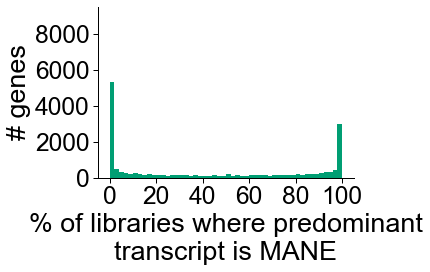

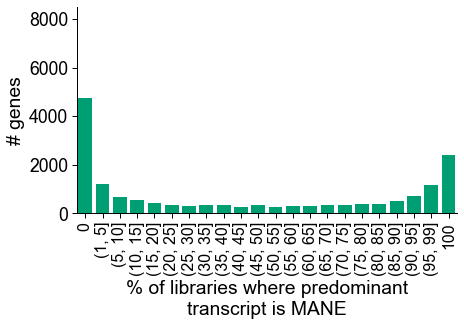

<Figure size 288x324 with 0 Axes>

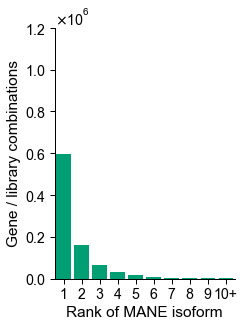

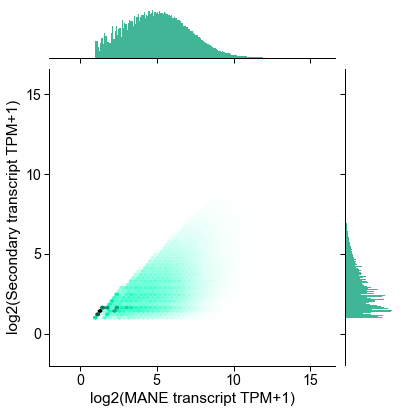

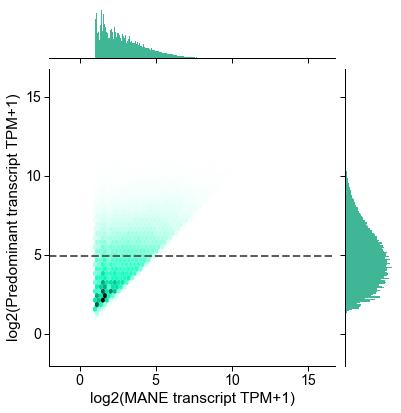

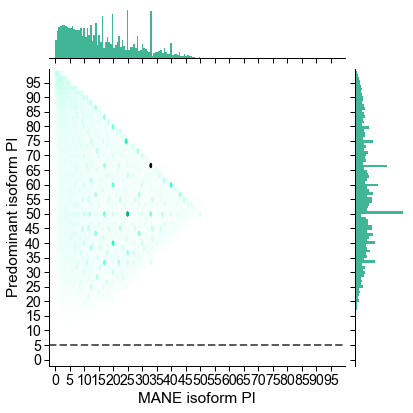

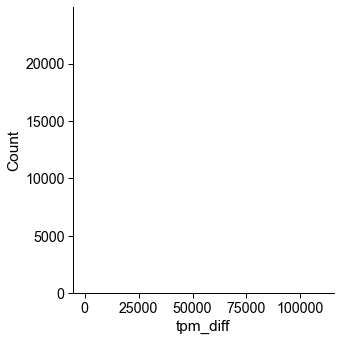

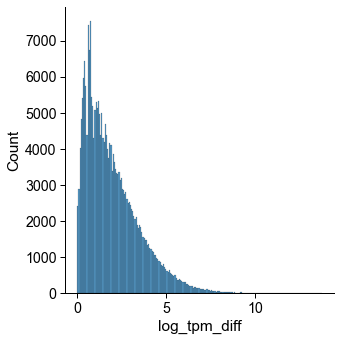

In [2]:
sg = swan.read(swan_file)
ca = cerberus.read(cerberus_h5)
mp_dfs = mane_analysis(sg, ca, 
                       ref_t_metadata,
                       ref_g_metadata,
                       'dataset',
                       min_tpm,
                       dataset_exp_gene,
                       config['lr']['mane']['pi_tpm'],
                       feats=['triplet'])

In [3]:
temp = mp_dfs['triplet'].copy(deep=True)

In [4]:
temp.head()

,tid_princ,dataset,triplet_tpm_princ,triplet_pi_princ,gid,gname,triplet_rank_princ,tid_mane,triplet_tpm_mane,triplet_pi_mane,triplet_rank_mane,tid_sec,triplet_tpm_sec,triplet_pi_sec,triplet_rank_sec,triplet_princ_is_mane,triplet_sec_is_mane
0,"ENSG00000285043[5,14,1]",wtc11_1_3,243.88269,97.440580,ENSG00000285043,ENSG00000285043,1,"ENSG00000285043[1,1,1]",0.000000,0.365631,4.0,"ENSG00000285043[6,15,1]",3.202962,1.279708,2.0,False,False
1,"ENSG00000285043[5,14,1]",wtc11_1_2,408.38892,97.247710,ENSG00000285043,ENSG00000285043,1,"ENSG00000285043[1,1,1]",0.000000,0.229358,5.0,"ENSG00000285043[4,14,1]",5.779089,1.376147,2.0,False,False
2,"ENSG00000285043[5,14,1]",wtc11_1_1,209.99948,97.889180,ENSG00000285043,ENSG00000285043,1,"ENSG00000285043[1,1,1]",2.264145,1.055409,2.0,"ENSG00000285043[1,1,1]",2.264145,1.055409,2.0,False,True
3,"ENSG00000285043[5,14,1]",upper_lobe_of_right_lung_1_1,60.49463,91.803276,ENSG00000285043,ENSG00000285043,1,"ENSG00000285043[1,1,1]",2.160522,3.278688,2.0,"ENSG00000285043[1,1,1]",2.160522,3.278688,2.0,False,True
4,"ENSG00000285043[5,14,1]",right_ventricle_myocardium_superior_1_1,542.48620,98.964490,ENSG00000285043,ENSG00000285043,1,NaN,0.000000,NaN,NaN,"ENSG00000285043[5,13,1]",3.243565,0.591716,2.0,False,False


In [5]:
meta_df = pd.read_csv(ref_t_metadata, sep='\t')
meta_df.head()

,tid,t_len,gid,gname,biotype,biotype_category,readthrough_transcript,MANE_Select,MANE_Plus_Clinical,tf
0,ENST00000000233.10,1038,ENSG00000004059.11,ARF5,protein_coding,protein_coding,False,True,False,False
1,ENST00000000412.8,2457,ENSG00000003056.8,M6PR,protein_coding,protein_coding,False,True,False,False
2,ENST00000000442.11,2281,ENSG00000173153.17,ESRRA,protein_coding,protein_coding,False,True,False,True
3,ENST00000001008.6,3725,ENSG00000004478.8,FKBP4,protein_coding,protein_coding,False,True,False,False
4,ENST00000001146.7,4562,ENSG00000003137.9,CYP26B1,protein_coding,protein_coding,False,True,False,False


In [15]:
assert len(temp.loc[(temp.tid_princ.str.contains('\[1,1,1\]'))&(temp.triplet_princ_is_mane==False)]) == 0

In [8]:
temp.loc[temp.tid_princ.str.contains('1,1,1')].head()

,tid_princ,dataset,triplet_tpm_princ,triplet_pi_princ,gid,gname,triplet_rank_princ,tid_mane,triplet_tpm_mane,triplet_pi_mane,triplet_rank_mane,tid_sec,triplet_tpm_sec,triplet_pi_sec,triplet_rank_sec,triplet_princ_is_mane,triplet_sec_is_mane
143,"ENSG00000284791[1,1,1]",upper_lobe_of_right_lung_1_1,4.321045,50.0,ENSG00000284791,SMIM41,1,"ENSG00000284791[1,1,1]",4.321045,50.0,1.0,"ENSG00000284791[1,1,2]",4.321045,50.0,2.0,True,False
145,"ENSG00000284791[1,1,1]",posterior_vena_cava_1_1,1.032485,100.0,ENSG00000284791,SMIM41,1,"ENSG00000284791[1,1,1]",1.032485,100.0,1.0,NaN,0.000000,NaN,NaN,True,False
147,"ENSG00000284791[1,1,1]",ovary_3_1,3.407201,100.0,ENSG00000284791,SMIM41,1,"ENSG00000284791[1,1,1]",3.407201,100.0,1.0,NaN,0.000000,NaN,NaN,True,False
148,"ENSG00000284791[1,1,1]",ovary_2_1,4.543627,100.0,ENSG00000284791,SMIM41,1,"ENSG00000284791[1,1,1]",4.543627,100.0,1.0,NaN,0.000000,NaN,NaN,True,False
149,"ENSG00000284791[1,1,1]",ovary_1_1,1.988835,100.0,ENSG00000284791,SMIM41,1,"ENSG00000284791[1,1,1]",1.988835,100.0,1.0,NaN,0.000000,NaN,NaN,True,False


In [ ]:
# gtf_df, _, _ = get_gtf_info(ver='v40_cerberus', how='iso')
# gtf_df = gtf_df.loc[gtf_df.MANE_Select==True]
# gtf_df['gid_stable'] = cerberus.get_stable_gid(gtf_df, 'gid')
# gtf_df = gtf_df[['tid', 'gid_stable']]
# gtf_df.rename({'tid': 'tid_mane'},
#               axis=1,
#               inplace=True)
# gtf_df.head()

In [44]:
# temp = mp_dfs['triplet'].copy(deep=True)
# temp = temp[['tid_princ', 'gid']].drop_duplicates()
# temp = temp.merge(gtf_df, 
#                   how='left',
#                   left_on='gid',
#                   right_on='gid_stable')


In [45]:
# temp.loc[temp.tid_mane.isnull()]

In [46]:
# temp.head()

In [47]:
# # limit to non-MANE predominant transcripts
# print(len(temp.index))
# temp = temp.loc[temp.tid_princ!=temp.tid_mane]
# print(len(temp.index))
            

In [48]:
# # merge in seqs for the MANE and non-MANE ORFs
# pp = pd.read_csv(pp_summary, sep='\t')

In [49]:
# temp

In [50]:
# pp

In [51]:
# # predominant orf stuff
# temp = temp.merge(pp[['tid', 'seq', 'nmd']],
#                   how='left', 
#                   left_on='tid_princ', 
#                   right_on='tid')
# temp.drop('tid', axis=1, inplace=True)
# temp.rename({'seq':'orf_seq_princ',
#              'nmd':'nmd_princ'}, axis=1, inplace=True)

# # mane orf stuff
# temp = temp.merge(pp[['tid', 'seq', 'nmd']],
#                   how='left',
#                   left_on='tid_mane', 
#                   right_on='tid')
# temp.drop('tid', axis=1, inplace=True)
# temp.rename({'seq':'orf_seq_mane',
#              'nmd':'nmd_mane'}, axis=1, inplace=True)
# temp.head()

## MANE analyses using samples

In [5]:
sg = swan.read(swan_file)
ca = cerberus.read(cerberus_h5)
mp_dfs = mane_analysis(sg, ca, 
                       ref_t_metadata,
                       ref_g_metadata,
                       'sample',
                       min_tpm,
                       sample_exp_gene,
                       config['lr']['mane']['pi_tpm'],
                       feats=['triplet'])